# Estimation in Higher Dimensions

The data-driven estimation procedure can be applied to data of any dimension. The primary reason that the PyDaddy package limits itself to one and two dimensions is its focus on visual diagnostics, which cannot be easily extended to higher dimensions.

Here, we demonstrate how to use the data-driven estimation technique to recover an SDE from a 3 dimensional time series, using the example of a Lorenz attractor perturbed by a constant additive noise.

In [ ]:
# Execute this cell to set up PyDaddy in your Colab environment.
%pip install git+https://github.com/tee-lab/PyDaddy.git

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pydaddy.fitters import *

We use the Lorenz system (with an additive noise term) for this example. The system is governed by the following equations.

$$
\begin{align}
\dot x &= s(y - x) + \sigma \eta_1(t) \\
\dot y &= rx - y - xz + \sigma \eta_2(t) \\
\dot z &= xy - bz + \sigma \eta_3(t)
\end{align}
$$

We simulate the system with $s = 10, r = 28, b = \frac83$ and $\sigma = 3$ and visualize the trajectory. For these parameter values, the system is in the chaotic regime. The strength of the noise, $\sigma$ is chosen such that it perturbs the system slightly around the strange attractor.

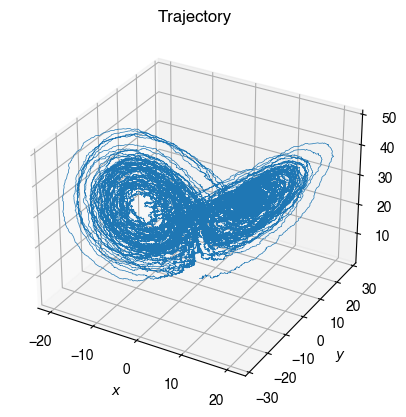

In [2]:
def lorenz(xyz, *, s=10, r=28, b=8/3):
    x, y, z = xyz
    x_dot = s*(y - x)
    y_dot = r*x - y - x*z
    z_dot = x*y - b*z
    return np.array([x_dot, y_dot, z_dot])

sigma = 3

dt = 0.001
T = 100000

xyz = np.empty((T, 3))
xyz[0] = (0., 1., 1.05)

for i in range(T - 1):
    xyz[i + 1] = xyz[i] + lorenz(xyz[i]) * dt + sigma * np.random.normal(size=(1, 3)) * np.sqrt(dt)

# Plot
ax = plt.figure().add_subplot(projection='3d')

ax.plot(*xyz.T, lw=0.5)
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")
ax.set_zlabel("$z$")
ax.set_title("Trajectory")

plt.show()

## Estimating drift

The simulated trajectory is in the form of a $T \times 3$ array where $T$ is the number of time points. We start by estimating the _instantaneous drift_ using finite differences.

In [3]:
F = (xyz[1:, :] - xyz[:-1, :]) / dt

To recover the expression for the corresponding drift functions $f_x, f_y, f_z$, we can use the custom library fitting functionality of PyDaddy. In this example, we define a library containing terms upto degree 2 in $x, y, z$.
We then we define a `fitter` object with an appropriate sparsification threshold (0.1 in this case).

In [4]:
library = [
    lambda x: np.ones_like(x[:, 0]), # constant
    lambda x: x[:, 0], # x
    lambda x: x[:, 1], # y
    lambda x: x[:, 2], # z
    lambda x: x[:, 0] ** 2, # x ** 2
    lambda x: x[:, 1] ** 2, # y ** 2
    lambda x: x[:, 2] ** 2, # z ** 2
    lambda x: x[:, 0] * x[:, 1], # xy
    lambda x: x[:, 0] * x[:, 2], # xz
    lambda x: x[:, 1] * x[:, 2], # yz
]

# Ignore the max_degree argument. While fitting with a custom library, this is not relevant.
fitter = PolyFitBase(threshold=.5, max_degree=1, library=library)

We can now use the fitter object to estimate the coefficients of $f_x, f_y, f_z$, by fitting the trajectory against the respective components of the instantaneous drift. 

The fitting result will be an array, specifying the corresponding coefficients for each term in the library.

In [5]:
fx, _ = fitter.fit(
    xyz[:-1, :],
    F[:, 0]
)

fx

array([  0.        , -10.0040064 ,   9.95579118,   0.        ,
         0.        ,   0.        ,   0.        ,   0.        ,
         0.        ,   0.        ])

In [6]:
fy, _ = fitter.fit(
    xyz[:-1, :],
    F[:, 1]
)

fy


array([ 0.        , 27.73160301, -0.93044157,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        , -0.993601  ,  0.        ])

In [7]:
fz, _ = fitter.fit(
    xyz[:-1, :],
    F[:, 2]
)

fz

array([-1.23761223,  0.        ,  0.        , -2.61818327,  0.        ,
        0.        ,  0.        ,  1.00253434,  0.        ,  0.        ])

## Estimating diffusion

Once the drift function is calculated, recall (refer to the manuscript) that the diffusion is computed from the residuals. 

Thus, we first compute the residuals by substracting the estimated drift component from the trajectory. Then, we take the outer product of the residual with itself to estimate the instantaneous diffusion components. Mathematically, if $X$ is the $T \times 3$ array containing the time series, and $\mathbf{f} = (f_x, f_y, f_z)$ is the estimated drift function, we do the following:

$$
\begin{align}
r &= X - f(X) \\
G &= X \otimes X^T  
\end{align}
$$

such that $G$ is a $T \times 3 \times 3$ array, containing the instantaneous diffusion coefficients.

In [8]:
def func_f(xyz):
    terms = np.array([f(xyz) for f in library])
    return np.array((fx @ terms, fy @ terms, fz @ terms)).T

res = (xyz[1:, :] - xyz[:-1, :]) - func_f(xyz[:-1, :]) * dt
G = np.einsum('ij,ik->ijk', res, res) / dt

We can now fit the individual comopnents of G, similar to how we did for $f$.

In [9]:
fitter = PolyFitBase(threshold=1, max_degree=1, library=library)
gx, _ = fitter.fit(
    xyz[:-1, :],
    G[:, 0, 0]
)

gx

array([8.99692211, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [10]:
fitter = PolyFitBase(threshold=1, max_degree=1, library=library)
gy, _ = fitter.fit(
    xyz[:-1, :],
    G[:, 1, 1]
)

gy

array([8.9323343, 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       ])

In [11]:
fitter = PolyFitBase(threshold=1, max_degree=1, library=library)
gz, _ = fitter.fit(
    xyz[:-1, :],
    G[:, 2, 2]
)

gz


array([8.99050489, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

We can verify that the cross-diffusion terms are zero.

In [12]:
fitter = PolyFitBase(threshold=1, max_degree=1, library=library)
gxy, _ = fitter.fit(
    xyz[:-1, :],
    G[:, 0, 1]
)

gxy

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

To summarize; our original drift and diffusion functions are:
$$
\begin{align}
f_x(x, y, z) &= -10x + 10 y \\
f_y(x, y, z) &= 28x - y - xz \\
f_z(x, y, z) &= xy - \frac83 z
\end{align}
$$

$$
g_x^2 = g_y^2 = g_z^2 = \sigma^2 = 9
$$

The estimated functions are (will vary slightly with simulations):
$$
\begin{align}
f_x(x, y, z) &= -10.077 x + 10.061 y \\
f_y(x, y, z) &= 28.198 x - 0.982 y - 1.007 xz \\
f_z(x, y, z) &= 0.994 xy - 2.625 z
\end{align}
$$

$$
\begin{align}
g_x^2 &= 8.989 \\
g_y^2 &= 9.020 \\
g_z^2 &= 8.972
\end{align}
$$